## Metric 3b: Number of days with heavy wildfire smoke density 

In [1]:
import numpy as np
import numpy.ma as ma
import os
from datetime import datetime, timedelta 
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

In [2]:
current_directory = os.path.dirname(os.getcwd())

In [3]:
# Daily Averaged WFS PM2.5 data by Census Tract
relative_path = "Output/Daily_Average_WFS_PM25_by_Census_Tract.csv"
grouped_data_path = os.path.join(current_directory, relative_path)
PM25_by_Tracts_WFS = pd.read_csv(grouped_data_path)

# Census Tracts Shapefile
relative_sf_path = "Raw_Data/Shapefiles/Tracts2020_Adjusted.shp"
grouped_data_CT_path = os.path.join(current_directory, relative_sf_path)
Tracts2020 = gpd.read_file(grouped_data_CT_path)
Tracts2020 = Tracts2020.to_crs(epsg=3338) # NAD AK Albers projection (better to project maps of AK only)

# Maps Output Folder Path
output_folder = os.path.join(current_directory, "Output")

In [4]:
# Convert Date to datetime and extract Year
PM25_by_Tracts_WFS['Date'] = pd.to_datetime(PM25_by_Tracts_WFS['Date'])
PM25_by_Tracts_WFS['Year'] = PM25_by_Tracts_WFS['Date'].dt.year

# Filter data to only include Wildfire Season (May-September)
WFS_M3b_Year_Tract = PM25_by_Tracts_WFS[PM25_by_Tracts_WFS['Date'].dt.month.isin([5, 6, 7, 8, 9])]

# Filter rows where PM2.5 is greater than 35.5
heavy_smoke_days_raw = WFS_M3b_Year_Tract[WFS_M3b_Year_Tract['PM2.5'] >= 35.5]

# Count occurrences for each tract and year
heavy_smoke_days = heavy_smoke_days_raw.groupby(['NAME', 'Year']).size().reset_index(name='heavy_smoke_days')

# Pivot the data to create columns for each year, with tract as the index
heavy_smoke_days_pivot = heavy_smoke_days.pivot(index='NAME', columns='Year', values='heavy_smoke_days').fillna(0)

# Add a "Total" column summing across all years for each tract
heavy_smoke_days_pivot['Total'] = heavy_smoke_days_pivot.sum(axis=1)

# Reset index if needed for further merging or display purposes
heavy_smoke_days_pivot.reset_index(inplace=True)

# Convert all counts to integers to remove decimals
heavy_smoke_days_pivot.loc[:, heavy_smoke_days_pivot.columns != 'NAME'] = heavy_smoke_days_pivot.loc[:, heavy_smoke_days_pivot.columns != 'NAME'].astype(int)

/tmp/ipykernel_191/3238263539.py:24: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  heavy_smoke_days_pivot.loc[:, heavy_smoke_days_pivot.columns != 'NAME'] = heavy_smoke_days_pivot.loc[:, heavy_smoke_days_pivot.columns != 'NAME'].astype(int)


In [5]:
# Some low wildfire years are being dropped because they have no values this high. Adding them back in

# Define the full range of years
all_years = list(range(2003, 2021))

# Ensure all years are present in the pivot table
missing_years = [year for year in all_years if year not in heavy_smoke_days_pivot.columns]

# Add missing years with 0 values
for year in missing_years:
    heavy_smoke_days_pivot[year] = 0

# Reorder columns to have years in ascending order, followed by 'Total'
columns_order = ['NAME'] + sorted(all_years) + ['Total']
heavy_smoke_days_pivot = heavy_smoke_days_pivot[columns_order]

# Ensure all counts are integers
heavy_smoke_days_pivot.loc[:, heavy_smoke_days_pivot.columns != 'NAME'] = heavy_smoke_days_pivot.loc[:, heavy_smoke_days_pivot.columns != 'NAME'].astype(int)
heavy_smoke_days_pivot

Year,NAME,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
0,Abbott Loop,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
1,Abbott Loop North,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
2,Abbott Loop West,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
3,Airport Heights,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
4,Airport Way Central,2,42,14,0,0,0,12,1,1,0,2,0,16,0,0,1,11,0,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Willow,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,3
153,Wonder Park,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
154,Woodland Park/Spenard,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,8,0,11
155,Yakutat,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [6]:
# All counts of days above 35.5 for the years of data we have
relative_heavy_smoke_days_path = "Output/WFS_M3b_heavy_smoke_days.csv"
grouped_heavy_smoke_days_path = os.path.join(current_directory, relative_heavy_smoke_days_path)
heavy_smoke_days_pivot.to_csv(grouped_heavy_smoke_days_path, index=False)

### Data Visualization

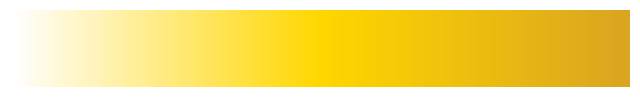

In [7]:
# Define colors: White -> Gold -> Goldenrod
colors = ["white", "gold", "goldenrod"]
WhiteToGoldenrod = mcolors.LinearSegmentedColormap.from_list("WhiteToGoldenrod", colors)

# Test the colormap with a gradient
gradient = np.linspace(0, 1, 256).reshape(1, -1)

fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(gradient, aspect="auto", cmap=WhiteToGoldenrod)
ax.set_axis_off()
plt.show()

## Panel Map

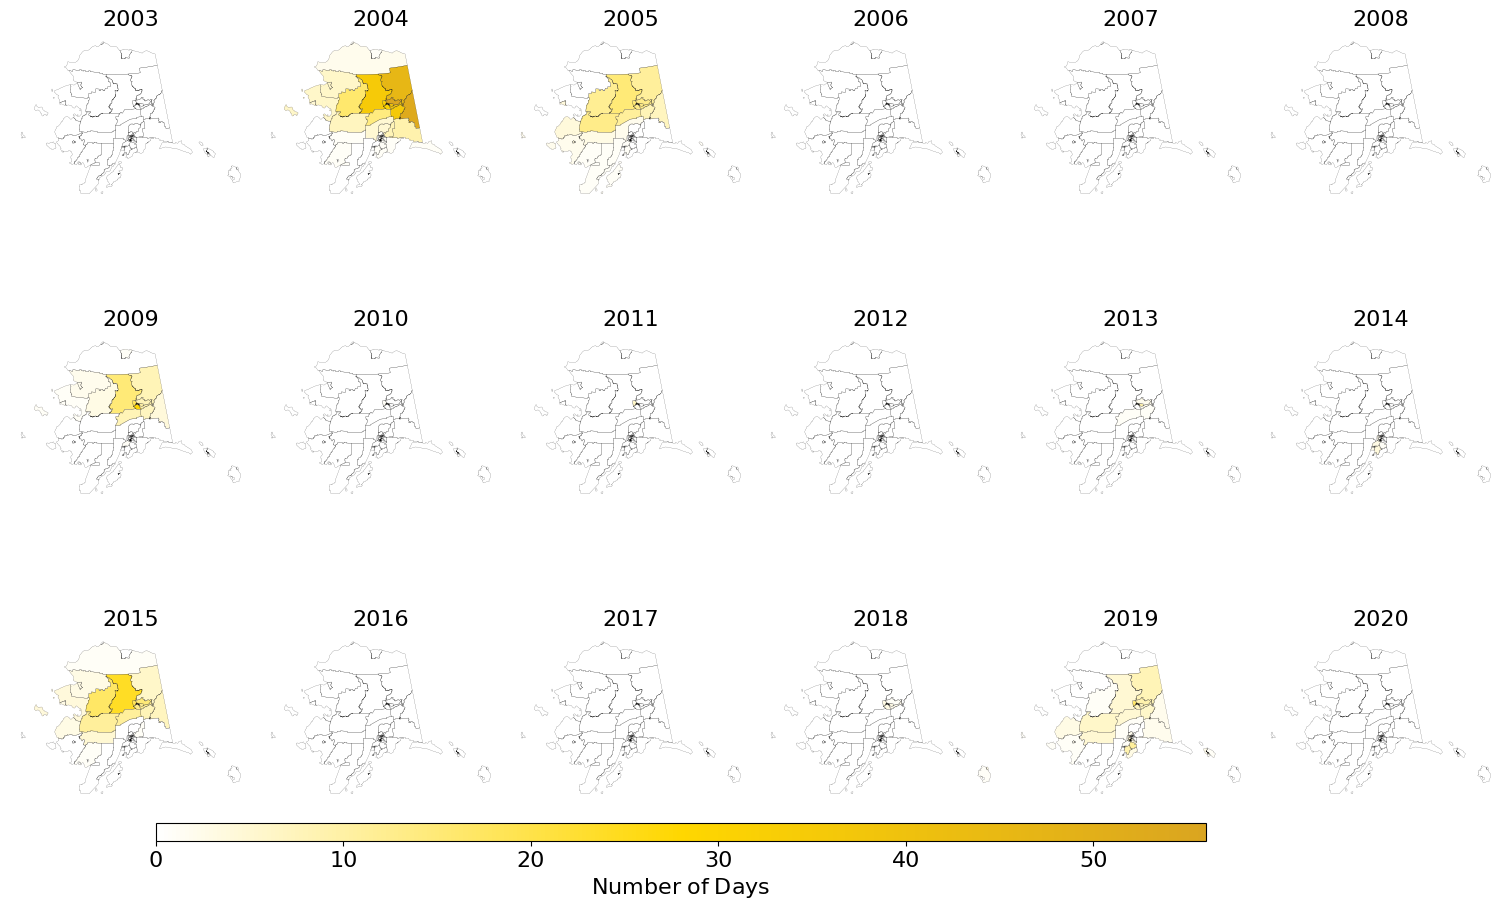

In [8]:
# Set the number of rows and columns for the panel (adjust if needed)
num_rows = 3
num_cols = 6

# Create a figure and GeoAxes with the Albers Equal Area projection for Alaska
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': alaska_albers}, figsize=(15, 9), constrained_layout=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Ensure only year columns are included for plotting (excluding 'NAME' and 'Total')
year_columns = [col for col in heavy_smoke_days_pivot.columns if col != 'NAME' and col != 'Total']

# Define min and max values for color scaling across all plots
vmin = 0
vmax = heavy_smoke_days_pivot[year_columns].max().max()  # Maximum value in all years for consistent color scaling

# Iterate over each year
for i, year in enumerate(year_columns):
    if i >= len(axes):
        break  # In case there are more years than subplots available
    
    # Prepare the data for the current year
    merged_data = Tracts2020.merge(
        pd.DataFrame({
            'NAME': heavy_smoke_days_pivot['NAME'],
            'Days_Above_Moderate': heavy_smoke_days_pivot[year]
        }),
        on='NAME', how='inner'
    )

    # Add thin black border to the shapefile data
    merged_data.boundary.plot(ax=axes[i], color='black', linewidth=0.10, transform=alaska_albers)

    # Plot the shapefile with color based on Days_Above_Moderate values
    merged_data.plot(
        ax=axes[i],
        column='Days_Above_Moderate',
        cmap=WhiteToGoldenrod,
        transform=alaska_albers,
        legend=False,
        vmin=vmin,
        vmax=vmax,
        edgecolor='none'
    )

    # Set plot title for each year
    axes[i].set_title(f"{year}", fontsize=16)

    # Remove axes ticks and labels
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    axes[i].set_frame_on(False)

# Adjust the position of the colorbar axes
ticks = np.arange(0, vmax + 10, 10)

# Adjust the position of the colorbar axes
cbar_ax = fig.add_axes([0.1, 0.03, 0.7, 0.02])

# Add colorbar to the figure
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToGoldenrod),
    cax=cbar_ax, orientation='horizontal', ticks=ticks
)
cbar.set_label(r'$\mathrm{Number\;of\;Days}$', fontsize=16)  # Increase title size
cbar_ax.tick_params(labelsize=16)  # Increase tick label size

# Export
output_file_path = f"{output_folder}/WFS_M3b_Panel.png"
plt.savefig(output_file_path, dpi=600, bbox_inches='tight')

plt.show()

## Annual Maps

In [9]:
# Define the Albers Equal Area projection for Alaska
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)

# Ensure only year columns are included for plotting (excluding 'NAME' and 'Total')
year_columns = [col for col in heavy_smoke_days_pivot.columns if col not in ['NAME', 'Total']]

# Define min and max values for color scaling across all plots
vmin = 0
vmax = heavy_smoke_days_pivot[year_columns].max().max()  # Maximum value in all years for consistent color scaling

# Generate tick positions for colorbar
ticks = np.arange(0, vmax + 10, 10)

# Iterate over each year
for year in year_columns:
    # Prepare the data for the current year
    merged_data = Tracts2020.merge(
        pd.DataFrame({
            'NAME': heavy_smoke_days_pivot['NAME'],
            'Days_Above_Moderate': heavy_smoke_days_pivot[year]
        }),
        on='NAME', how='inner'
    )
    
    # Create a new figure for each year
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': alaska_albers}, figsize=(10, 8))
    
    # Add thin black border to the shapefile data
    merged_data.boundary.plot(ax=ax, color='black', linewidth=0.10, transform=alaska_albers)

    # Plot the shapefile with color based on Days_Above_Moderate values
    merged_data.plot(
        ax=ax,
        column='Days_Above_Moderate',
        cmap=WhiteToGoldenrod,
        transform=alaska_albers,
        legend=False,
        vmin=vmin,
        vmax=vmax,
        edgecolor='none'
    )

    # Add a colorbar for the individual map
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=WhiteToGoldenrod),
        ax=ax,
        orientation='horizontal',
        fraction=0.046, pad=0.04, ticks=ticks
    )
    cbar.set_label(r'$\mathrm{Number\;of\;Days}$')

    # Set the title for the map
    ax.set_title(f"Days Above 35.5 PM2.5 - {year}", fontsize=14)

    # Remove axes ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')  # Remove the frame

    # Save the individual map to the output folder
    output_file_path = f"{output_folder}/WFS_M3b_{year}.png"
    plt.savefig(output_file_path, dpi=600, bbox_inches='tight')
    
    # Close the figure to release memory
    plt.close(fig)

print("All individual maps have been saved to:", output_folder)

All individual maps have been saved to: /mnt/c/Users/nrathauda/OneDrive - University of Alaska/NIMHD K01 - wildfire and birth outcomes/Alaska_wildfire-smoke-metrics_2025/Output


## Cumulative Map

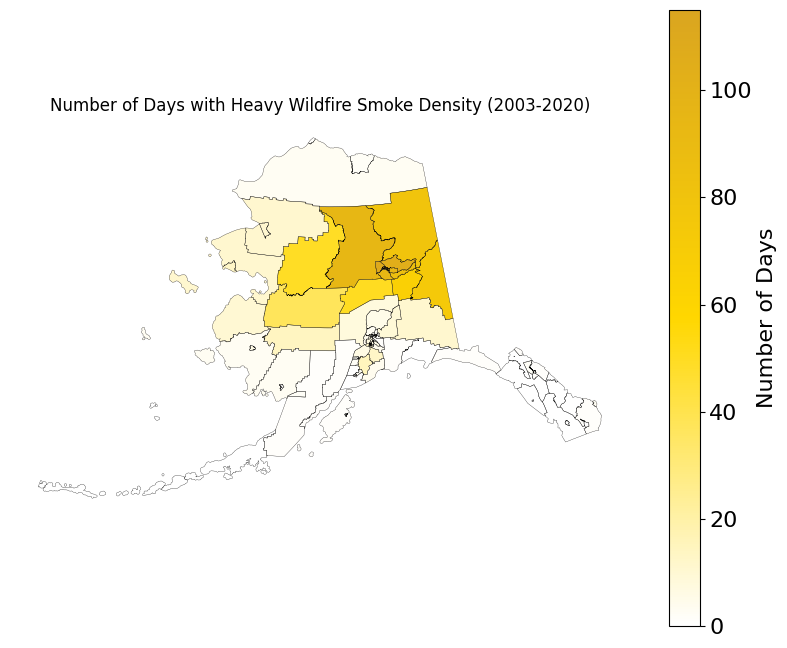

In [10]:
# Merge shapefile with the average PM2.5 data
merged_data = Tracts2020.merge(heavy_smoke_days_pivot, on='NAME', how='inner')

# Create a figure and GeoAxes with the Albers Equal Area projection
alaska_albers = ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=50)
fig, ax = plt.subplots(subplot_kw={'projection': alaska_albers}, figsize=(10, 8))

# Add thin black border to the shapefile data
Tracts2020.boundary.plot(ax=ax, color='black', linewidth=0.20, transform=alaska_albers)
vmin = 0
vmax = merged_data['Total'].max()

# Plot the shapefile with color based on Average_PM25 values
plot = merged_data.plot(
    ax=ax, column='Total', cmap=WhiteToGoldenrod, legend=True, transform=alaska_albers, vmin=vmin, vmax=vmax
)

# Colorbar label text sizing
cbar = plot.get_figure().get_axes()[-1] 
cbar.set_ylabel("Number of Days", fontsize=16)  # Increase title size
cbar.tick_params(labelsize=16)  # Increase tick label size

# Remove axes ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.axis('off')

# Export without title
wfs_m3b_cumul_relative_path = "Output/WFS_M3b_Cumulative_Map.png"
wfs_m3b_cumul_path = os.path.join(current_directory, wfs_m3b_cumul_relative_path)
plt.savefig(wfs_m3b_cumul_path, dpi=300, bbox_inches='tight')

# Set plot title
ax.set_title('Number of Days with Heavy Wildfire Smoke Density (2003-2020)')

# Export with title
wfs_m3b_cumul_relative_path = "Output/WFS_M3b_Cumulative_Map_Titled.png"
wfs_m3b_cumul_path = os.path.join(current_directory, wfs_m3b_cumul_relative_path)
plt.savefig(wfs_m3b_cumul_path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()